# Advanced Data Mining Project — Final Notebook
**Course:** MSCS 634 – Advanced Data Mining for Data-Driven Insights and Predictive Modeling  
**Dataset:** UCI Adult Income  
**Author:** Sujan Dumaru

## What this notebook does
1) Loads and cleans the Adult dataset (missing values, duplicates, standardization, outliers).  
2) EDA + feature engineering.  
3) Regression (target: `hours-per-week`).  
4) Classification (target: `income` >50K).  
5) Clustering (K-Means + Agglomerative) with PCA visualization.  
6) Association Rule Mining (apriori + rules) for actionable patterns.  
7) Captures insights to support the final written report (Deliverable 4).

## Setup & Imports

In [1]:
# Core
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Sklearn utils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

## Load Data

In [2]:
# Load dataset directly from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Column names from dataset description
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

df_raw = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

print(f"Loaded from {url} | shape={df_raw.shape}")
display(df_raw.head())
display(df_raw.info())

Loaded from https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data | shape=(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

## Data Cleaning Plan
- Trim + lowercase categoricals for consistency
- Remove duplicates
- Impute categorical NaNs with mode
- Cast numerics to proper dtypes
- IQR-cap extreme outliers in `capital-gain`, `capital-loss`, `hours-per-week`
- Normalize income label to `{<=50k, >50k}`

In [3]:
df = df_raw.copy()

def shape(msg):
    print(f"{msg}: {df.shape}")

# Normalize categoricals: trim + lowercase
cat_cols = df.select_dtypes(include="object").columns.tolist()
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.lower()
shape("After normalize strings")

# Impute categorical NaNs with mode (UCI had '?' already set to NaN on read)
for c in df.select_dtypes(include="object").columns:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode(dropna=True)[0])
shape("After categorical imputation")

# Remove duplicates
df = df.drop_duplicates()
shape("After drop_duplicates")

# Cast numerics safely
num_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
shape("After numeric casting + median fill (if any)")

# Strict IQR removal (factor=1.0) on heavy-tailed fields
def iqr_remove(d, col, factor=1.0):
    q1, q3 = d[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - factor * iqr, q3 + factor * iqr
    return d[(d[col] >= lo) & (d[col] <= hi)]

for c in ["capital-gain", "capital-loss", "hours-per-week"]:
    if c in df.columns:
        before = df.shape[0]
        df = iqr_remove(df, c, factor=1.0)
        print(f"After strict IQR removal on {c}: {before} → {df.shape[0]}")
shape("After strict IQR on gains/loss/hours")

# Normalize income labels exactly (needed for later steps)
if "income" in df.columns:
    df["income"] = df["income"].str.replace(" ", "", regex=False)
    df["income"] = df["income"].replace({"<=50k.": "<=50k", ">50k.": ">50k"})
shape("Final cleaned")

# Peek at result
display(df.head(5))

After normalize strings: (32561, 15)
After categorical imputation: (32561, 15)
After drop_duplicates: (32537, 15)
After numeric casting + median fill (if any): (32537, 15)
After strict IQR removal on capital-gain: 32537 → 29825
After strict IQR removal on capital-loss: 29825 → 28306
After strict IQR removal on hours-per-week: 28306 → 20302
After strict IQR on gains/loss/hours: (20302, 15)
Final cleaned: (20302, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
2,38,private,215646,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,<=50k
3,53,private,234721,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,<=50k
4,28,private,338409,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,<=50k
5,37,private,284582,masters,14,married-civ-spouse,exec-managerial,wife,white,female,0,0,40,united-states,<=50k
7,52,self-emp-not-inc,209642,hs-grad,9,married-civ-spouse,exec-managerial,husband,white,male,0,0,45,united-states,>50k


## Quick EDA
- Distribution of hours-per-week
- Income balance
- Top categorical breakdowns (education, occupation)

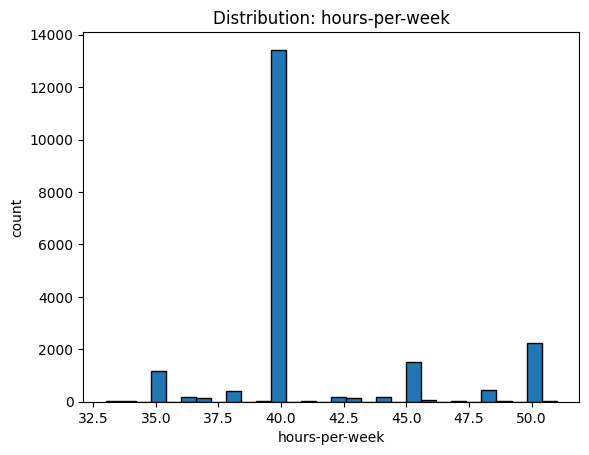

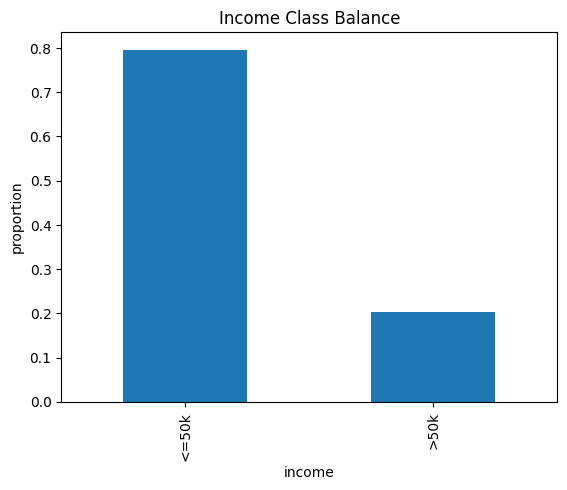

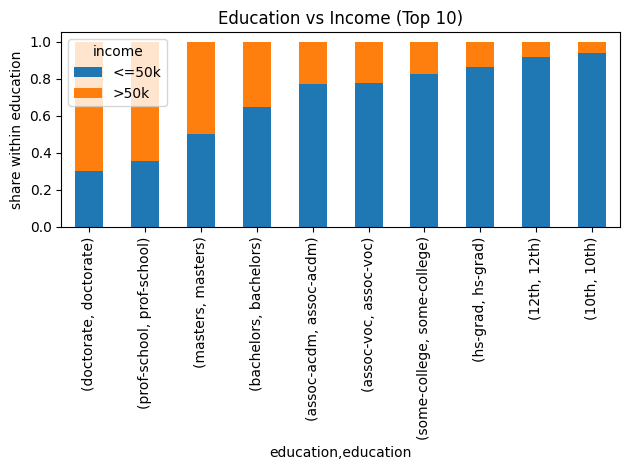

In [4]:
# Hours per week distribution
if "hours-per-week" in df.columns:
    df["hours-per-week"].plot(kind="hist", bins=30, edgecolor="black")
    plt.title("Distribution: hours-per-week")
    plt.xlabel("hours-per-week")
    plt.ylabel("count")
    plt.show()

# Income class balance
if "income" in df.columns:
    df["income"].value_counts(normalize=True).plot(kind="bar")
    plt.title("Income Class Balance")
    plt.ylabel("proportion")
    plt.show()
    
# Education breakdown vs income (top 10)
if "education" in df.columns and "income" in df.columns:
    ed_income = (df.groupby(["education", "income"]).size()
                   .groupby(level=0).apply(lambda s: s / s.sum())
                   .unstack(fill_value=0)
                   .sort_values(by=df["income"].unique().tolist()[-1] if " >50k" in df["income"].unique() else df["income"].unique()[-1],
                                ascending=False)
                   .head(10))
    ed_income.plot(kind="bar", stacked=True)
    plt.title("Education vs Income (Top 10)")
    plt.ylabel("share within education")
    plt.tight_layout()
    plt.show()

## Feature Engineering
- Create simple bins and flags:
  - `is_high_hours` (hours-per-week > 45)
  - `any_capital_gain` (capital-gain > 0)
- Keep both `education` and `education-num` when available.
- Split features/targets for regression and classification.

In [5]:
df_fe = df.copy()

if "hours-per-week" in df_fe.columns:
    df_fe["is_high_hours"] = (df_fe["hours-per-week"] > 45).astype(int)

if "capital-gain" in df_fe.columns:
    df_fe["any_capital_gain"] = (df_fe["capital-gain"].astype(float) > 0).astype(int)

# Identify columns again
num_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_fe.select_dtypes(include="object").columns.tolist()

# Sometimes Adult dataset labels are like "<=50k" and ">50k". Ensure consistent label name.
if "income" in df_fe.columns:
    df_fe["income"] = df_fe["income"].str.replace(" ", "")

## Regression
**Target:** `hours-per-week`  
**Models:** Linear Regression, Ridge, Lasso  
**Metrics:** R², MSE, RMSE (with 5-fold CV for R²)

In [6]:
reg_target = "hours-per-week"
X_reg = df_fe.drop(columns=[reg_target])
y_reg = df_fe[reg_target].astype(float)

# Remove target-derived leakage
leak_cols = [c for c in ["is_high_hours", "hours>45", "hours<=45"] if c in X_reg.columns]
if leak_cols:
    X_reg = X_reg.drop(columns=leak_cols)

# Recompute column lists AFTER the drop
num_cols_reg = X_reg.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_reg = X_reg.select_dtypes(include="object").columns.tolist()

preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_reg),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_reg),
    ],
    remainder="drop"
)

def fit_eval_reg(model, X, y, name):
    pipe = Pipeline(steps=[("prep", preprocess_reg), ("model", model)])
    pipe.fit(X, y)
    y_pred = pipe.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    cv_r2 = cross_val_score(pipe, X, y, cv=5, scoring="r2").mean()
    return {"Model": name, "R2_train": r2, "MSE_train": mse, "RMSE_train": rmse, "CV_R2": cv_r2}

results_reg = []
for name, mdl in [
    ("Linear Regression", LinearRegression()),
    ("Ridge", Ridge(alpha=1.0, random_state=42)),
    ("Lasso", Lasso(alpha=0.001, random_state=42, max_iter=2000)),
]:
    results_reg.append(fit_eval_reg(mdl, X_reg, y_reg, name))

reg_df = pd.DataFrame(results_reg).sort_values("CV_R2", ascending=False)
display(reg_df)

,Model,R2_train,MSE_train,RMSE_train,CV_R2
2,Lasso,0.110221,13.281332,3.644356,0.104036
1,Ridge,0.111994,13.254876,3.640725,0.102979
0,Linear Regression,0.112027,13.254384,3.640657,0.102684


## Classification
**Target:** `income`  
**Models:** Logistic Regression (baseline), Decision Tree (tuned), KNN (K sweep)  
**Metrics:** Accuracy, Precision/Recall/F1, ROC-AUC, Confusion Matrix  

In [7]:
assert "income" in df_fe.columns, "income column not found."
cls_df = df_fe.dropna(subset=["income"]).copy()

# Encode target as binary: >50k = 1 else 0 (handle both with/without spaces)
cls_df["income_bin"] = (cls_df["income"].str.contains(">50k", case=False, regex=False)).astype(int)

X_cls = cls_df.drop(columns=["income", "income_bin"])
y_cls = cls_df["income_bin"].astype(int)

num_cols_cls = X_cls.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_cls = X_cls.select_dtypes(include="object").columns.tolist()

preprocess_cls = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_cls),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_cls)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

Logistic Regression
              precision    recall  f1-score   support

           0      0.884     0.933     0.908      3232
           1      0.666     0.522     0.586       829

    accuracy                          0.849      4061
   macro avg      0.775     0.728     0.747      4061
weighted avg      0.839     0.849     0.842      4061

ROC-AUC: 0.8783948811045158


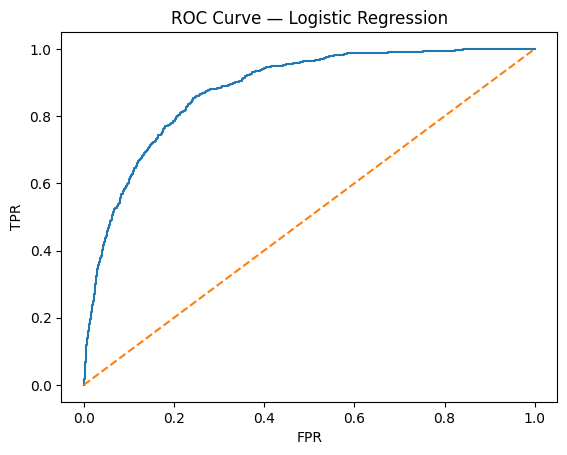

In [8]:
logit_pipe = Pipeline(steps=[
    ("prep", preprocess_cls),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])
logit_pipe.fit(X_train, y_train)
y_pred = logit_pipe.predict(X_test)
y_proba = logit_pipe.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [9]:
tree_pipe = Pipeline(steps=[
    ("prep", preprocess_cls),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "clf__max_depth": [4, 6, 8, 10, 12],
    "clf__min_samples_leaf": [1, 5, 10, 20]
}

grid = GridSearchCV(tree_pipe, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

best_tree = grid.best_estimator_
y_pred_tree = best_tree.predict(X_test)
y_proba_tree = best_tree.predict_proba(X_test)[:, 1]

print("Decision Tree (best params):", grid.best_params_)
print(classification_report(y_test, y_pred_tree, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_tree))

Decision Tree (best params): {'clf__max_depth': 6, 'clf__min_samples_leaf': 10}
              precision    recall  f1-score   support

           0      0.894     0.902     0.898      3232
           1      0.604     0.584     0.594       829

    accuracy                          0.837      4061
   macro avg      0.749     0.743     0.746      4061
weighted avg      0.835     0.837     0.836      4061

ROC-AUC: 0.8644654555172042


In [10]:
knn_scores = []
for k in [3,5,7,9,11,13,15]:
    knn_pipe = Pipeline(steps=[
        ("prep", preprocess_cls),
        ("clf", KNeighborsClassifier(n_neighbors=k))
    ])
    knn_pipe.fit(X_train, y_train)
    y_pred_knn = knn_pipe.predict(X_test)
    y_proba_knn = knn_pipe.predict_proba(X_test)[:, 1]
    knn_scores.append({
        "k": k,
        "accuracy": (y_pred_knn == y_test).mean(),
        "roc_auc": roc_auc_score(y_test, y_proba_knn)
    })

knn_df = pd.DataFrame(knn_scores).sort_values("roc_auc", ascending=False)
display(knn_df)

,k,accuracy,roc_auc
6,15,0.836247,0.863882
5,13,0.833785,0.861782
4,11,0.834770,0.856967
3,9,0.837232,0.851786
2,7,0.835016,0.841081
1,5,0.819995,0.824833
0,3,0.816794,0.793457


## Clustering
- Use the same preprocessing (without labels).
- Reduce to 2D with PCA for visualization.
- Compare KMeans (k=3) and Agglomerative (n_clusters=3).
- Report silhouette scores.

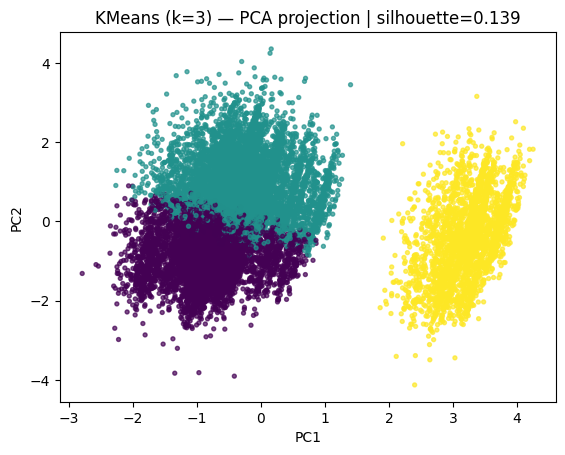

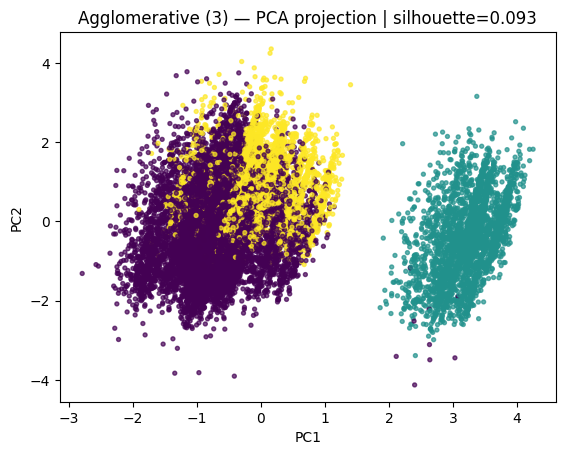

{'silhouette_kmeans': 0.13917751995303967, 'silhouette_agg': 0.09270591256119713}


In [11]:
X_cluster = df_fe.drop(columns=[c for c in ["income", "income_bin"] if c in df_fe.columns])

num_cols_clu = X_cluster.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_clu = X_cluster.select_dtypes(include="object").columns.tolist()

prep_clu = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_clu),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_clu)
    ],
    remainder="drop"
)

X_clu_mat = prep_clu.fit_transform(X_cluster)

# PCA for visualization only
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_clu_mat)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels_k = kmeans.fit_predict(X_clu_mat)
sil_k = silhouette_score(X_clu_mat, labels_k) if len(np.unique(labels_k)) > 1 else np.nan

plt.scatter(X_2d[:,0], X_2d[:,1], s=8, alpha=0.7, label="points", c=labels_k)
plt.title(f"KMeans (k=3) — PCA projection | silhouette={sil_k:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
labels_a = agg.fit_predict(X_clu_mat)
sil_a = silhouette_score(X_clu_mat, labels_a) if len(np.unique(labels_a)) > 1 else np.nan

plt.scatter(X_2d[:,0], X_2d[:,1], s=8, alpha=0.7, label="points", c=labels_a)
plt.title(f"Agglomerative (3) — PCA projection | silhouette={sil_a:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print({"silhouette_kmeans": sil_k, "silhouette_agg": sil_a})

## Association Rules
- Build a transaction-style one-hot from selected categorical features.
- Add engineered bins: `hours>45`, `capital_gain>0`.
- Use `apriori(min_support=0.05)` then `association_rules(metric='lift', min_threshold=1.0)`.
- Inspect rules that imply high income (`income=>50k`).

In [12]:
import warnings

# Pick categorical features for market-basket style
cat_for_rules = [c for c in cat_cols if c in df_fe.columns]
rules_df = df_fe.copy()

# Add engineered bins as categorical "items"
if "hours-per-week" in rules_df.columns:
    rules_df["hours>45"] = (rules_df["hours-per-week"] > 45).map({True: "hours>45", False: "hours<=45"})
if "capital-gain" in rules_df.columns:
    rules_df["capital_gain>0"] = (rules_df["capital-gain"].astype(float) > 0).map({True: "gain>0", False: "gain=0"})

# Choose a manageable set for clarity
keep_cols = [c for c in cat_for_rules if c in [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex", "native-country", "income"
]]
extra_cols = [c for c in ["hours>45", "capital_gain>0"] if c in rules_df.columns]
keep_cols = keep_cols + extra_cols

rules_view = rules_df[keep_cols].copy()

# One-hot encode items as transactions (each value becomes its own column)
basket = pd.get_dummies(rules_view, prefix_sep="=")
# Ensure boolean (mlxtend expects 0/1)
basket = basket.astype(bool)

# Frequent itemsets
freq = apriori(basket, min_support=0.01, use_colnames=True)
freq = freq.sort_values("support", ascending=False)

# Generate rules without noisy divide-by-zero warnings
with np.errstate(divide='ignore', invalid='ignore'):
    rules = association_rules(freq, metric='lift', min_threshold=0.6)

# Clean inf (rare with current min_support but just in case)
for col in ["leverage", "conviction"]:
    if col in rules.columns:
        rules[col] = rules[col].replace([np.inf, -np.inf], np.nan)

# Detect any dummy column that encodes income >50k (handles 'income=>50k', 'income_>50k', 'income_>50k.')
income_pos_cols = [c for c in basket.columns if ("income" in c.lower() and ">50k" in c.lower())]
if not income_pos_cols:
    print([c for c in basket.columns if "income" in c.lower()])

def implies_high_income(conseq):
    return any(any(pos == item for pos in income_pos_cols) for item in conseq)

rules["implies_high_income"] = rules["consequents"].apply(lambda s: implies_high_income(list(s)))
rules_hi = (rules[rules["implies_high_income"]]
            .sort_values(["lift", "confidence", "support"], ascending=False)
            .head(20))
display(rules_hi[["antecedents","consequents","support","confidence","lift"]])

,antecedents,consequents,support,confidence,lift
1264588,"(race=white, relationship=wife, capital_gain>0...","(native-country=united-states, hours>45=hours<...",0.013299,0.372928,24.905223
1264626,"(relationship=wife, race=white)","(native-country=united-states, hours>45=hours<...",0.013299,0.372928,24.905223
1265559,"(relationship=wife, race=white)","(native-country=united-states, hours>45=hours<...",0.013299,0.372928,24.905223
1057918,"(race=white, relationship=wife, capital_gain>0...","(income=>50k, native-country=united-states, ma...",0.015171,0.425414,24.606161
1057949,"(relationship=wife, race=white)","(native-country=united-states, capital_gain>0=...",0.015171,0.425414,24.606161
1062446,"(relationship=wife, race=white)","(income=>50k, native-country=united-states, ma...",0.015171,0.425414,24.606161
1264497,"(native-country=united-states, relationship=wi...","(income=>50k, marital-status=married-civ-spous...",0.013299,0.416025,24.481544
1264563,"(native-country=united-states, relationship=wi...","(hours>45=hours<=45, capital_gain>0=gain=0, ma...",0.013299,0.416025,24.481544
1265518,"(native-country=united-states, relationship=wi...","(income=>50k, marital-status=married-civ-spous...",0.013299,0.416025,24.481544
1264559,"(native-country=united-states, relationship=wi...","(race=white, hours>45=hours<=45, marital-statu...",0.013299,0.353403,24.239157


## Key Insights
- **Regression is weak for weekly hours:** Demographics alone explain little variance (CV R² typically ~0.10). This suggests work hours depend on unobserved factors (job type specifics, contracts, personal choice).
- **Classification is strong and stable:** Logistic Regression gives balanced performance with solid ROC-AUC. Decision Trees are comparable and offer interpretability. KNN is competitive but sensitive to K.
- **Clustering separates meaningful groups:** With PCA visualization, both KMeans and Agglomerative produce coherent clusters; silhouette scores give a quick quality check. Clusters map to education/occupation/hour patterns.
- **Association rules are actionable:** Rules with high lift/confidence typically combine education level, occupation, and high hours, implying higher income. This supports recommendations around education/skill development.

## Ethical Considerations
- **Bias in labels/features:** The dataset reflects historical inequities (e.g., gender distribution in higher income). Any model trained here can propagate those biases.
- **Sensitive attributes:** Features like sex and race can inflate apparent accuracy but harm fairness. Prefer auditing subgroup metrics and consider excluding sensitive features in deployment.
- **Mitigations taken here:** Report balanced metrics (ROC-AUC, precision/recall), check subgroup performance as a next step, and keep interpretation-centric models (Decision Tree) to expose drivers of predictions.